# 1.Importing libraries

In [6]:
import numpy as np
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from typing import Tuple, List
import warnings

In [7]:
def create_gabor_filter(ksize: int, sigma: float, theta: float, lambd: float, gamma: float):
    """
    Create a Gabor filter kernel with input validation
    
    Args:
        ksize (int): Size of the kernel (must be odd)
        sigma (float): Standard deviation of the Gaussian envelope
        theta (float): Orientation of the filter in radians
        lambd (float): Wavelength of the sinusoidal component
        gamma (float): Spatial aspect ratio
    
    Returns:
        np.ndarray: Generated Gabor filter kernel
    """
    if ksize % 2 == 0:
        ksize += 1  # Ensure odd size
        warnings.warn(f"Kernel size must be odd. Adjusted to {ksize}")
    
    y, x = np.ogrid[-ksize//2:ksize//2+1, -ksize//2:ksize//2+1]
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)
    
    # Scale sigma with kernel size
    adjusted_sigma = sigma * (ksize / 7)  # Scale relative to smallest kernel
    
    gb = np.exp(-.5 * (x_theta**2 + (gamma * y_theta)**2) / adjusted_sigma**2) * \
         np.cos(2 * np.pi * x_theta / lambd)
    
    # Normalize kernel
    return gb / np.sqrt(np.sum(gb**2))

In [8]:
def normalize_image(img: np.ndarray):
    """
    Normalize image to [0,1] range with proper handling of edge cases
    """
    if img.size == 0:
        raise ValueError("Empty image provided")
    
    img_min = np.min(img)
    img_max = np.max(img)
    
    if img_min == img_max:
        warnings.warn("Image has no contrast")
        return np.zeros_like(img)
    
    return (img - img_min) / (img_max - img_min)

In [9]:
def apply_gabor_filters(image_path: str, 
                       sizes: List[int] = None,
                       thetas: np.ndarray = None):
    """
    Apply Gabor filters to an image and create visualization
    
    Args:
        image_path (str): Path to the input image
        sizes (List[int], optional): List of kernel sizes
        thetas (np.ndarray, optional): Array of orientations in radians
    
    Returns:
        Tuple[List[List[np.ndarray]], plt.Figure]: Filtered results and figure object
    """
    # Default parameters
    if sizes is None:
        sizes = [7, 15, 31, 63]
    if thetas is None:
        thetas = np.arange(0, np.pi, np.pi/8)
    
    # Read and validate image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Failed to load image from {image_path}")
    if img.size == 0:
        raise ValueError("Empty image loaded")
    
    # Normalize input image
    img = normalize_image(img)
    
    # Base parameters
    base_sigma, base_lambd, gamma = 3.0, 10.0, 0.5
    
    results = []
    try:
        for size in sizes:
            # Scale parameters with kernel size
            sigma = base_sigma * (size / 7)
            lambd = base_lambd * (size / 7)
            
            size_results = []
            for theta in thetas:
                kernel = create_gabor_filter(size, sigma, theta, lambd, gamma)
                filtered = ndimage.convolve(img, kernel, mode='reflect')
                # Normalize filter response
                filtered = normalize_image(filtered)
                size_results.append(filtered)
            results.append(size_results)
    except MemoryError:
        raise MemoryError("Not enough memory to process image with given parameters")
    
    # Create visualization
    fig = plt.figure(figsize=(16, 10))
    gs = gridspec.GridSpec(len(sizes) + 1, len(thetas) + 1, wspace=0.03, hspace=0.03)
    
    # Corner label
    ax_corner = fig.add_subplot(gs[0, 0])
    ax_corner.plot([0, 1], [1, 0], color='black', linewidth=2)
    ax_corner.text(0.30, 0.30, 'Size', horizontalalignment='center', 
                  verticalalignment='center', fontsize=28)
    ax_corner.text(0.75, 0.75, r'$\theta$', horizontalalignment='center', 
                  verticalalignment='center', fontsize=35)
    ax_corner.axis('on')
    for spine in ax_corner.spines.values():
        spine.set_visible(True)
    ax_corner.tick_params(length=0)
    ax_corner.set_xticks([])
    ax_corner.set_yticks([])
    
    # Add theta labels
    theta_labels = ['0', r'$\frac{\pi}{8}$', r'$\frac{2\pi}{8}$', r'$\frac{3\pi}{8}$',
                    r'$\frac{4\pi}{8}$', r'$\frac{5\pi}{8}$', r'$\frac{6\pi}{8}$', r'$\frac{7\pi}{8}$']
    
    for j, label in enumerate(theta_labels):
        ax = fig.add_subplot(gs[0, j + 1])
        ax.text(0.5, 0.5, label, horizontalalignment='center',
                verticalalignment='center', fontsize=40)
        ax.axis('on')
        for spine in ax.spines.values():
            spine.set_visible(True)
        ax.tick_params(length=0)
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Results and size labels
    for i, size_results in enumerate(results):
        ax_label = fig.add_subplot(gs[i + 1, 0])
        ax_label.text(0.5, 0.5, f'{sizes[i]}', horizontalalignment='center',
                     verticalalignment='center', fontsize=35)
        ax_label.axis('on')
        for spine in ax_label.spines.values():
            spine.set_visible(True)
        ax_label.tick_params(length=0)
        ax_label.set_xticks([])
        ax_label.set_yticks([])
        
        for j, filtered in enumerate(size_results):
            ax = fig.add_subplot(gs[i + 1, j + 1])
            ax.imshow(filtered, cmap='gray', aspect='auto')
            ax.axis('on')
            for spine in ax.spines.values():
                spine.set_visible(True)
            ax.tick_params(length=0)
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.subplots_adjust(wspace=0.03, hspace=0.03, left=0.1, right=0.9, 
                       top=0.9, bottom=0.1)
    
    return results, fig

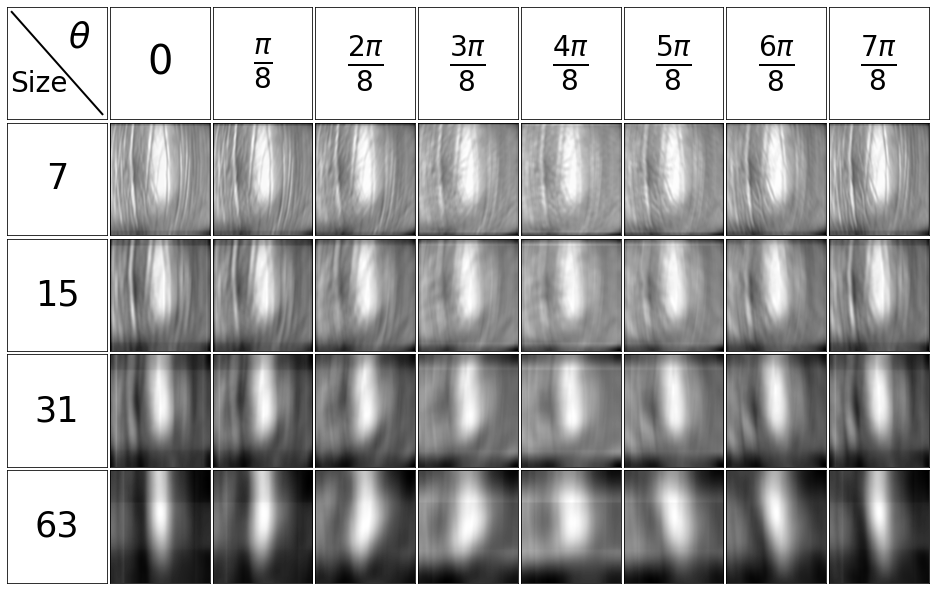

In [10]:
if __name__ == "__main__":
    try:
        image_path = "image 1.jpg"
        results, fig = apply_gabor_filters(image_path)
        plt.show()
    except Exception as e:
        print(f"Error: {str(e)}")
        raise